In [2]:
import json
import shutil
import subprocess
import sys
import time
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path
from tqdm import tqdm
from pathlib import Path
from skimage.exposure import match_histograms

thispath = Path().resolve()
base_path = thispath.parent
sys.path.insert(0, str(base_path))

import elastix.elastix_utils as e_utils
from utils.metrics import mutual_information
from utils import utils
from preprocessing import min_max_norm

### Define all necessary paths

In [2]:
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas'
mni_atlas_path = data_path / 'mni_atlas'

## Register all images to all images

This is done with two objectives, to first decide the best image to register the brains to generate a probabilistic atlas based only in train cases that will be later registered to all train + val cases, and for later in the case we do the multi atlas approach all the images must be registered to the image we want to generate the inference for

### First we tried doing the registrations without doing any preprocessing technique other than N4 bias field correction

In [ ]:
# Define all necessary paths
experiment_name = 'ava'
param_maps_to_use = ['Par0010affine.txt', 'Par0010bspline.txt']
param_maps_to_use2 = ['Parameters.Par0009.affine.txt', 'Parameters.Par0009.elastic.txt']
params_path =  base_path / 'elastix' / 'parameter_maps'
output_path = base_path / 'experiments/elastix'
times_path = base_path /'experiments/elastix/Par0010bspline/ava/times.json'

# Define the list of train and validation cases
train_cases = list(train_set_path.iterdir())
val_cases = list(val_set_path.iterdir())
all_cases = val_cases + train_cases

# Define the name of the parameter file utilized
pm = param_maps_to_use[-1]
parameters_filename = params_path / 'Par0010' / pm

# Define a list of conflictive cases that will be reprocessed with parameter file Par0009
missing = [
    'IBSR_12-IBSR_17', 'IBSR_07-IBSR_17', 'IBSR_07-IBSR_13',
    'IBSR_07-IBSR_16', 'IBSR_08-IBSR_17', 'IBSR_08-IBSR_16',
    'IBSR_08-IBSR_04']

# Store the times required for the registrations, define the placeholders
if times_path.exists():
    with open(times_path, 'r') as json_file:
        times = json.load(json_file)
else:
    times = {}

# Define fixed imgage to use
for j, fix_img_path in enumerate(all_cases):
    case_fix = fix_img_path.name

    # Define output paths
    output_pm_path = output_path / pm.rstrip('.txt') / experiment_name
    output_pm_path = output_pm_path / case_fix
    output_pm_path.mkdir(exist_ok=True, parents=True)
    
    # Register all other images
    for k, mov_img_path in tqdm(enumerate(all_cases), total=len(all_cases)):
        
        # Define inpupt/output paths
        case_mov = mov_img_path.name
        result_path = output_pm_path / case_mov
        result_path.mkdir(exist_ok=True, parents=True)

        # if f'{case_fix}-{case_mov}' not in missing:
        #     continue

        # Define all the necessary images paths
        fix_path = fix_img_path / f'{case_fix}_n4.nii.gz'
        mov_path = mov_img_path / f'{case_mov}_n4.nii.gz'
        fix_mask_path = fix_img_path / f'{case_fix}_brain_mask.nii.gz'
        mov_mask_path = mov_img_path / f'{case_mov}_brain_mask.nii.gz'
        seg_path = mov_mask_path.parent / f'{case_mov}_seg.nii.gz'
        
        # Don't register same image just copy it
        if case_mov == case_fix:
            shutil.copytree(mov_img_path, result_path, dirs_exist_ok=True)
            continue

        # Read and modify parameters file
        field_value_pairs = [
            ('WriteResultImage', 'true'),
            ('ResultImageFormat', 'nii.gz')
        ]
        e_utils.modify_field_parameter_map(field_value_pairs, parameters_filename)

        # Create temporary image files with the preprocessings included and 
        # also for the selected binary masks.
        res_path = result_path / 'res_tmp'
        res_path.mkdir(exist_ok=True, parents=True)

        param_maps_to_use_ = [str(params_path / 'Par0010' / p) for p in param_maps_to_use] 

        # Register the images get a printed message if the registration fails
        try:
            transform_map_path = res_path.parent/f'TransformParameters_{case_mov}_n4.txt'
            if not transform_map_path.exists():
                start = time.time()
                transform_map_path = e_utils.elastix_wrapper(
                    fix_path, mov_path, res_path.parent, param_maps_to_use_,
                    fix_mask_path, mov_mask_path, verbose=False, keep_just_useful_files=False
                )
                reg_time = time.time()-start
                times[f'{case_fix}-{case_mov}'] = reg_time
            # Correct transformation parameters file
            field_value_pairs = [
                ('ResultImageFormat', 'nii.gz'),
                ('ResultImagePixelType', "int"),
                ('FinalBSplineInterpolationOrder', '0')
            ]
            e_utils.modify_field_parameter_map(field_value_pairs, transform_map_path)
            
            # Transform gt segmentations
            out_seg_path = result_path / f'r_{seg_path.name}'
            e_utils.transformix_wrapper(
                seg_path, out_seg_path, transform_map_path,
                points=False, verbose=False, keep_just_useful_files=False)
        except:
            print(f'Case {case_fix}-{case_mov} failed')

with open(times_path, 'w') as json_file:
    json.dump(times, json_file, indent=4, separators=(',', ': '))

After trying, the following cases coundn't be registered with param file 0009 or 0010.

'IBSR_12-IBSR_17' - 'IBSR_07-IBSR_17' -  'IBSR_07-IBSR_13' - 'IBSR_07-IBSR_16' - 'IBSR_08-IBSR_17' - 'IBSR_08-IBSR_16' - 'IBSR_08-IBSR_04'

Either way we kept doing the next stages

Compute mutual information between all the registered images (atlases) and the target (image that the atlases were registered to)

In [ ]:
# Define the path where the images are stored
output_pm_path = output_path / 'Par0010bspline/ava'

# Define the placeholder for the mi
mi_df = []
idxs = []

# For all targets
for ref in tqdm(output_pm_path.iterdir(), total = len(list(output_pm_path.iterdir()))):
    ref_img_name = ref.name
    idxs.append(ref_img_name)

    # Define the placeholder for the row
    mi_row = {}
    
    # Load the target image
    ref_img = sitk.GetArrayFromImage(sitk.ReadImage(str(ref/ref_img_name/f'{ref_img_name}_n4.nii.gz')))
    cols = []

    # For all atlases
    for mov_img_path in ref.iterdir():
        # Load the atlas
        mov_case = mov_img_path.name
        mov_img = sitk.GetArrayFromImage(sitk.ReadImage(str(mov_img_path/f'{mov_case}_n4.nii.gz')))
        
        # Compute the mutual information
        mi = mutual_information(ref_img, mov_img)
        mi_row[(mov_case)] = mi

        cols.append(mov_case)
    mi_df.append(mi_row)
    
# Generate the dataframe and store it
mi_df = pd.DataFrame(mi_df, index=idxs, columns=cols)
# mi_df.to_csv(base_path/'experiments/elastix/Par0010bspline/mi_ava.csv')

Plot the mutual information ad pick a target case

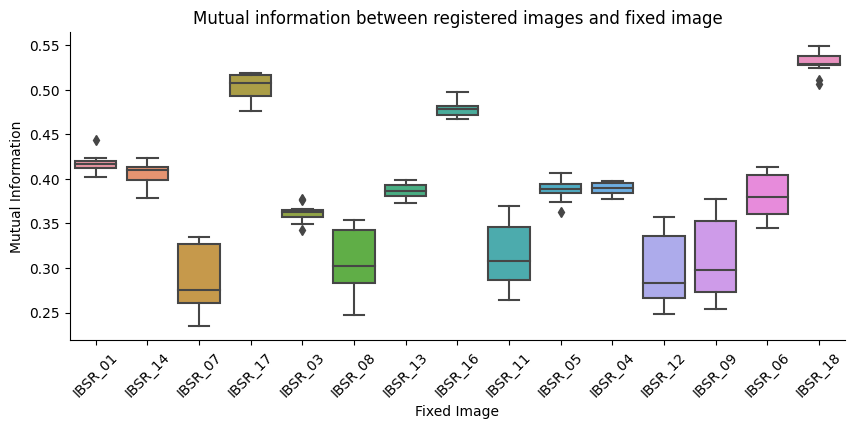

In [52]:
# Reformat the dataframe
mi_df['fixed_image'] = mi_df.index.values
plot_df = pd.melt(
    mi_df,
    id_vars=['fixed_image'],
    value_vars=[i for i in mi_df.columns if i!='fixed_image'], ignore_index=False
)
plot_df.columns = ['Fixed Image', 'Moving Image', 'Mutual Information']
plot_df = plot_df.loc[plot_df['Mutual Information'] < 0.8, :]

# Plot
plt.figure(figsize=(10, 4))
plt.title('Mutual information between registered images and fixed image')
sns.boxplot(plot_df, x='Fixed Image', y='Mutual Information')
plt.xticks(rotation=45)
sns.despine()
plt.show()

### Generate the probabilistic atlas based on case IBSR_18 as target

In [14]:
reg_path = base_path / 'experiments/elastix/Par0010bspline/atlas_gen/IBSR_18'

# Reference values
ref_atlas = sitk.ReadImage(str(base_path / 'data/mni_atlas/atlas.nii.gz'))
ref_img_path = reg_path / 'IBSR_18/IBSR_18_n4.nii.gz'
ref_img = sitk.ReadImage(str(ref_img_path))
ref_img_array = sitk.GetArrayFromImage(ref_img)

# Configs
n_classes = 4
n_volumes = len(list(reg_path.iterdir()))
ref_shape = ref_img_array.shape
labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

# Create acumulators
atlases = np.zeros(
    (n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
mean_vol = np.zeros_like(ref_img_array).astype('float32')

for i, case_path in tqdm(enumerate(reg_path.iterdir()), total=len(list(reg_path.iterdir()))):
    # Get names
    case = case_path.name
    img_name = f'{case}_n4.nii.gz'
    labels_name = f'r_{case}_seg.nii.gz' if case != 'IBSR_18' else f'{case}_seg.nii.gz'

    # Acumulate mean image
    img = sitk.GetArrayFromImage(sitk.ReadImage(str(case_path/img_name)))
    img = min_max_norm(img, max_val=255, percentiles=(1, 99), dtype='uint8')
    mean_vol += img / n_volumes
    
    # Acumulate prob atlas image
    lab_img = sitk.GetArrayFromImage(sitk.ReadImage(str(case_path/labels_name)))    
    for c in range(atlases.shape[0]):
        atlases[c, :, :, :] += np.where(lab_img == c, 1, 0)/n_volumes

# Save results
output_path = base_path / "data/ibsr_atlas"
output_path.mkdir(exist_ok=True, parents=True)
for c in range(atlases.shape[0]):
    utils.save_img_from_array_using_referece(
        atlases[c, :, :, :], ref_img, output_path / f'atlas_{labels_keys[c]}.nii.gz')
utils.save_img_from_array_using_referece(atlases, ref_atlas, output_path / 'atlas.nii.gz')
utils.save_img_from_array_using_referece(mean_vol, ref_img, output_path / 'template.nii.gz')

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


# Try preprocessing when registering

We decided to explore different preprocessing stages that may help to perform the registration step. Performing matching histograms before doing the registration solved the problem, and the results were visually consistent.

In [3]:
# Define all necessary paths
experiment_name = 'ava_preproc'
param_maps_to_use = ['Par0010affine.txt', 'Par0010bspline.txt']
param_maps_to_use2 = ['Parameters.Par0009.affine.txt', 'Parameters.Par0009.elastic.txt']
params_path =  base_path / 'elastix' / 'parameter_maps'
output_path = base_path / 'experiments/elastix'
times_path = base_path / 'experiments/elastix/Par0010bspline/ava_preproc/times.json'

# Define the list of train and validation cases
train_cases = list(train_set_path.iterdir())
val_cases = list(val_set_path.iterdir())
all_cases = val_cases + train_cases

# Define the name of the parameter file utilized
pm = param_maps_to_use[-1]
parameters_filename = params_path / 'Par0010' / pm

# Store registration times
if times_path.exists():
    with open(times_path, 'r') as json_file:
        times = json.load(json_file)
else:
    times = {}

# Define target image to use
for j, fix_img_path in enumerate(all_cases):
    case_fix = fix_img_path.name
    
    # Define output paths
    output_pm_path = output_path / pm.rstrip('.txt') / experiment_name
    output_pm_path = output_pm_path / case_fix
    output_pm_path.mkdir(exist_ok=True, parents=True)
    
    # Load the target image
    fix_path = fix_img_path / f'{case_fix}_n4.nii.gz'
    fix_img = sitk.ReadImage(str(fix_path))
    fix_img_array = sitk.GetArrayFromImage(fix_img)
    
    # For all atlas images:
    for k, mov_img_path in tqdm(enumerate(all_cases), total=len(all_cases)):
        # Define inpupt/output paths
        case_mov = mov_img_path.name
        result_path = output_pm_path / case_mov
        result_path.mkdir(exist_ok=True, parents=True)
        
        # Define all necessary image paths
        mov_path = mov_img_path / f'{case_mov}_n4.nii.gz'
        fix_mask_path = fix_img_path / f'{case_fix}_brain_mask.nii.gz'
        mov_mask_path = mov_img_path / f'{case_mov}_brain_mask.nii.gz'
        seg_path = mov_mask_path.parent / f'{case_mov}_seg.nii.gz'
        
        # Don't register same image, jsut copy it
        if case_mov == case_fix:
            shutil.copytree(mov_img_path, result_path, dirs_exist_ok=True)
            continue

        # Read and modify parameters file
        field_value_pairs = [
            ('WriteResultImage', 'true'),
            ('ResultImageFormat', 'nii.gz')
        ]
        e_utils.modify_field_parameter_map(field_value_pairs, parameters_filename)

        # Create temporary image files with the preprocessings included and 
        # also for the selected binary masks.
        res_path = result_path / 'res_tmp'
        res_path.mkdir(exist_ok=True, parents=True)

        param_maps_to_use_ = [str(params_path / 'Par0010' / p) for p in param_maps_to_use] 

        # Preprocess the images, perfom histogram matching from atlas to target
        mov_img = sitk.ReadImage(str(mov_path))
        mov_img_array = sitk.GetArrayFromImage(mov_img)
        mov_img_array[mov_img_array!=0] = match_histograms(
            mov_img_array[mov_img_array!=0], fix_img_array[fix_img_array!=0])

        # Store the temporary image
        temp_fix_img_path = res_path / f'{case_fix}_n4.nii.gz'
        utils.save_img_from_array_using_referece(fix_img_array, fix_img, temp_fix_img_path)
        temp_mov_img_path = res_path / f'{case_mov}_n4.nii.gz'
        utils.save_img_from_array_using_referece(mov_img_array, mov_img, temp_mov_img_path)

        # Register, and print a warning if the image couldn't be registered
        try:
            transform_map_path = res_path.parent/f'TransformParameters_{case_mov}_n4.txt'
            if not transform_map_path.exists():
                start = time.time()
                transform_map_path = e_utils.elastix_wrapper(
                    fix_path, temp_mov_img_path, res_path.parent, param_maps_to_use_,
                    fix_mask_path, mov_mask_path, verbose=False, keep_just_useful_files=False
                )
                reg_time = time.time()-start
                times[f'{case_fix}-{case_mov}'] = reg_time
            # Correct transformation parameters file
            field_value_pairs = [
                ('ResultImageFormat', 'nii.gz'),
                ('ResultImagePixelType', "int"),
                ('FinalBSplineInterpolationOrder', '0')
            ]
            e_utils.modify_field_parameter_map(field_value_pairs, transform_map_path)
            
            # Transform gt segmentations
            out_seg_path = result_path / f'r_{seg_path.name}'
            e_utils.transformix_wrapper(
                seg_path, out_seg_path, transform_map_path,
                points=False, verbose=False, keep_just_useful_files=False)
        except:
            print(f'Case {case_fix}-{case_mov} failed')

# Store the registration times
with open(times_path, 'w') as json_file:
    json.dump(times, json_file, indent=4, separators=(',', ': '))

100%|██████████| 15/15 [15:10<00:00, 60.73s/it]


MI computation

In [6]:
# Define the path where the images are stored
output_pm_path = output_path / 'Par0010bspline/ava_preproc'

# Define the placeholder for the mi
mi_df = []
idxs = []

# For all targets
for ref in tqdm(output_pm_path.iterdir(), total = len(list(output_pm_path.iterdir()))):
    ref_img_name = ref.name
    idxs.append(ref_img_name)

    # Define the placeholder for the row
    mi_row = {}

    # Load the target image
    ref_img = sitk.GetArrayFromImage(sitk.ReadImage(str(ref/ref_img_name/f'{ref_img_name}_n4.nii.gz')))
    cols = []

    # For all atlases
    for mov_img_path in ref.iterdir():
        
        # Load the atlas
        mov_case = mov_img_path.name
        mov_img = sitk.GetArrayFromImage(sitk.ReadImage(str(mov_img_path/f'{mov_case}_n4.nii.gz')))

        # Compute the mutual information
        mi = mutual_information(ref_img, mov_img)
        mi_row[(mov_case)] = mi
        # print(ref_img_name, mov_case, mi)
        cols.append(mov_case)
    mi_df.append(mi_row)

# Generate the dataframe and store it
mi_df = pd.DataFrame(mi_df, index=idxs, columns=cols)
# mi_df.to_csv(base_path/'experiments/elastix/Par0010bspline/mi_ava_preproc.csv')
mi_df

100%|██████████| 15/15 [02:03<00:00,  8.26s/it]


,IBSR_18,IBSR_01,IBSR_14,IBSR_07,IBSR_17,IBSR_03,IBSR_08,IBSR_13,IBSR_16,IBSR_11,IBSR_05,IBSR_04,IBSR_12,IBSR_09,IBSR_06
IBSR_18,1.424297,0.535883,0.546700,0.533753,0.530045,0.530107,0.537782,0.532683,0.547983,0.531548,0.542567,0.511997,0.515055,0.529525,0.542184
IBSR_01,0.414407,1.011999,0.418485,0.423538,0.412965,0.414736,0.418094,0.419719,0.407056,0.423053,0.443143,0.399288,0.420162,0.417723,0.422880
IBSR_14,0.417959,0.408592,1.053885,0.428423,0.394675,0.410886,0.424433,0.405973,0.408528,0.424930,0.414538,0.384399,0.417512,0.419740,0.415124
IBSR_07,0.280063,0.272161,0.284558,0.875652,0.258259,0.270767,0.330359,0.265434,0.280745,0.314723,0.282043,0.264055,0.336691,0.327997,0.308337
IBSR_17,0.518517,0.520871,0.514447,0.495318,1.285687,0.508218,0.499010,0.513632,0.518101,0.496976,0.516694,0.507868,0.481446,0.497211,0.507556
IBSR_03,0.359247,0.362460,0.373579,0.367674,0.347223,0.869601,0.365773,0.362472,0.363733,0.363811,0.373521,0.354928,0.361619,0.368058,0.364451
IBSR_08,0.304300,0.298074,0.311127,0.352669,0.289597,0.293923,0.863889,0.288773,0.298843,0.332255,0.306955,0.279394,0.350153,0.342658,0.333863
IBSR_13,0.387620,0.399309,0.395249,0.385026,0.387375,0.395790,0.386595,0.992774,0.380310,0.384921,0.394499,0.378936,0.378278,0.383217,0.386679
IBSR_16,0.485483,0.473902,0.495453,0.488327,0.469499,0.482361,0.490613,0.475069,1.205210,0.486082,0.481703,0.470515,0.477684,0.485409,0.486420
IBSR_11,0.317155,0.315245,0.338754,0.376156,0.286861,0.320971,0.365795,0.306161,0.315802,0.911413,0.335198,0.293666,0.372165,0.369626,0.345359


### Plot the mutual information and pick the target image

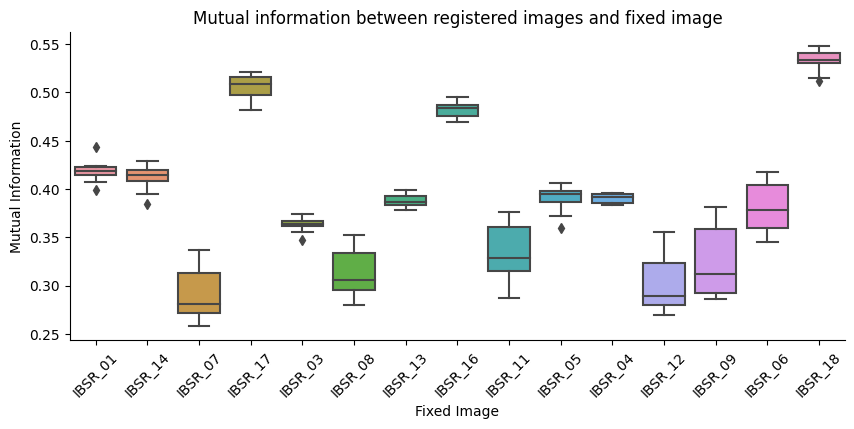

In [12]:
# Reformat the dataframe
mi_df['fixed_image'] = mi_df.index.values
plot_df = pd.melt(
    mi_df,
    id_vars=['fixed_image'],
    value_vars=[i for i in mi_df.columns if i!='fixed_image'], ignore_index=False
)
plot_df.columns = ['Fixed Image', 'Moving Image', 'Mutual Information']
plot_df = plot_df.loc[plot_df['Mutual Information'] < 0.8, :]

# Plot
plt.figure(figsize=(10, 4))
plt.title('Mutual information between registered images and fixed image')
sns.boxplot(plot_df, x='Fixed Image', y='Mutual Information')
plt.xticks(rotation=45)
sns.despine()
plt.show()

case IBSR_18 is selected as target one

### Generate the probabilistic atlas based on case IBSR_18 as target

In [3]:
reg_path = base_path / 'experiments/elastix/Par0010bspline/atlas_gen_p/IBSR_18'

# Reference values
ref_atlas = sitk.ReadImage(str(base_path / 'data/mni_atlas/atlas.nii.gz'))
ref_img_path = reg_path / 'IBSR_18/IBSR_18_n4.nii.gz'
ref_img = sitk.ReadImage(str(ref_img_path))
ref_img_array = sitk.GetArrayFromImage(ref_img)

# Configs
n_classes = 4
n_volumes = len(list(reg_path.iterdir()))
ref_shape = ref_img_array.shape
labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

# Create acumulators
atlases = np.zeros(
    (n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
mean_vol = np.zeros_like(ref_img_array).astype('float32')

for i, case_path in tqdm(enumerate(reg_path.iterdir()), total=len(list(reg_path.iterdir()))):
    # Get names
    case = case_path.name
    img_name = f'{case}_n4.nii.gz'
    labels_name = f'r_{case}_seg.nii.gz' if case != 'IBSR_18' else f'{case}_seg.nii.gz'

    # Acumulate mean image
    img = sitk.GetArrayFromImage(sitk.ReadImage(str(case_path/img_name)))
    # img = min_max_norm(img, max_val=255,  dtype='uint8') #percentiles=(1, 99),
    mean_vol += img / n_volumes
    
    # Acumulate prob atlas image
    lab_img = sitk.GetArrayFromImage(sitk.ReadImage(str(case_path/labels_name)))    
    for c in range(atlases.shape[0]):
        atlases[c, :, :, :] += np.where(lab_img == c, 1, 0)/n_volumes

# Save results
output_path = base_path / "data/ibsr_atlas_p"
output_path.mkdir(exist_ok=True, parents=True)
for c in range(atlases.shape[0]):
    utils.save_img_from_array_using_referece(
        atlases[c, :, :, :], ref_img, output_path / f'atlas_{labels_keys[c]}.nii.gz')
utils.save_img_from_array_using_referece(atlases, ref_img, output_path / 'atlas.nii.gz', True)

utils.save_img_from_array_using_referece(mean_vol, ref_img, output_path / 'template.nii.gz')
mean_vol = min_max_norm(mean_vol, max_val=255, percentiles=(1, 100), dtype='uint8')
utils.save_img_from_array_using_referece(mean_vol, ref_img, output_path / 'template_n.nii.gz')

100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


### Construct all probabistic atlases for multiatlas approach

In [14]:
# Define all necessary paths
ava_path = base_path / 'experiments/elastix/Par0010bspline/ava_preproc'
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'

train_cases = [case.name for case in train_set_path.iterdir()]
val_cases = [case.name for case in val_set_path.iterdir()]

# Configs
n_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

# Define fixed imgage to use
for j, fix_case_path in enumerate(ava_path.iterdir()):

    case_fix = fix_case_path.name
    partition = 'train_set' if case_fix in train_cases else 'validation_set'
    mov_cases = list(fix_case_path.iterdir())
    
    # Define output paths
    output_path = data_path / partition / case_fix
    output_file_path = output_path / f'{case_fix}_multi-atlas.nii.gz'    

    # Reference values
    ref_img = sitk.ReadImage(str(output_path / f'{case_fix}_n4.nii.gz'))
    ref_img_array = sitk.GetArrayFromImage(ref_img)
    ref_shape = ref_img_array.shape

    # Configs
    n_volumes = len(mov_cases)-1

    # Create acumulators
    atlases = np.zeros(
        (n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
    mean_vol = np.zeros_like(ref_img_array).astype('float32')

    for k, mov_case_path in tqdm(enumerate(mov_cases), total=len(mov_cases)):
        # Define inpupt/output paths
        case_mov = mov_case_path.name
        if case_mov == case_fix:
            continue

        # Get names
        labels_name = f'r_{case_mov}_seg.nii.gz'
        
        # Acumulate prob atlas image
        lab_img = sitk.GetArrayFromImage(sitk.ReadImage(str(mov_case_path/labels_name)))    
        for c in range(atlases.shape[0]):
            atlases[c, :, :, :] += np.where(lab_img == c, 1, 0) / n_volumes

        # Save results
        utils.save_img_from_array_using_referece(atlases, ref_img, output_file_path, True)

100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


# Register probabilistic atlas generated with train iamges and IBSR_18 as target to all train images

Generate a brain mask for the probabilistic atlas

In [3]:
# Define all necessary paths
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas_p'
mni_atlas_path = data_path / 'mni_atlas'

# Load the atlas
temp_mask_path = our_atlas_path / 'template_brain_mask.nii.gz'
temp_path = our_atlas_path / 'template_n.nii.gz'
temp = sitk.ReadImage(str(temp_path))
temp_array = sitk.GetArrayFromImage(temp)
# Generate the mask
temp_array = np.where(temp_array>0, 1, 0).astype('uint8')
# Store
utils.save_img_from_array_using_referece(temp_array, temp, temp_mask_path)

In [19]:
# Define all necessary paths
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas_p'
mni_atlas_path = data_path / 'mni_atlas'

# Configs
n_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}
param_maps_to_use = ['Par0010affine.txt', 'Par0010bspline.txt']
params_path =  base_path / 'elastix' / 'parameter_maps'
pm = param_maps_to_use[-1]
parameters_filename = params_path / 'Par0010' / pm

# Define train and validation cases
train_cases = [p.name for p in train_set_path.iterdir()]
val_cases = [p.name for p in val_set_path.iterdir()]
all_cases = val_cases + train_cases

# Define fixed imgage to use
for j, case_fix in tqdm(enumerate(all_cases), total=len(all_cases)):

    partition = 'train_set' if case_fix in train_cases else 'validation_set'
    
    # Define output paths
    output_path = data_path / partition / case_fix
    output_file_path = output_path / f'{case_fix}_atlas.nii.gz'    

    # Reference values
    ref_img = sitk.ReadImage(str(output_path / f'{case_fix}_n4.nii.gz'))
    ref_img_array = sitk.GetArrayFromImage(ref_img)
    ref_shape = ref_img_array.shape
    
    # Probabilistic atlas paths and load images
    template_path = our_atlas_path / 'template_n.nii.gz'
    atlas_path = our_atlas_path / 'atlas.nii.gz'
    template_img = sitk.ReadImage(str(template_path))
    atlas_img = sitk.ReadImage(str(atlas_path))

    # Define the fix and moving images and brain masks
    mov_path = template_path
    mov_mask_path = our_atlas_path / 'template_brain_mask.nii.gz'
    
    fix_path = output_path /  f'{case_fix}_n4.nii.gz'
    fix_mask_path = output_path /f'{case_fix}_brain_mask.nii.gz'
    
    fix_img = sitk.ReadImage(str(fix_path))
    fix_img_array = sitk.GetArrayFromImage(fix_img)
    
    # Read and modify parameters file
    field_value_pairs = [
        ('WriteResultImage', 'true'),
        ('ResultImageFormat', 'nii.gz')
    ]
    e_utils.modify_field_parameter_map(field_value_pairs, parameters_filename)

    # Create temporary image files with the preprocessings included and 
    # also for the selected binary masks.
    res_path = output_path / 'res_tmp'
    res_path.mkdir(exist_ok=True, parents=True)

    param_maps_to_use_ = [str(params_path / 'Par0010' / p) for p in param_maps_to_use] 

    # Preprocess the images
    mov_img = sitk.ReadImage(str(mov_path))
    mov_img_array = sitk.GetArrayFromImage(mov_img)

    # Perform histogram matching as it proved to be helpful before
    mov_img_array[mov_img_array != 0] = match_histograms(
        mov_img_array[mov_img_array!=0], fix_img_array[fix_img_array!=0])

    # Store the preprocessed imaged
    temp_fix_img_path = res_path / f'{case_fix}_n4.nii.gz'
    utils.save_img_from_array_using_referece(fix_img_array, fix_img, temp_fix_img_path)
    temp_mov_img_path = res_path / 'template.nii.gz'
    utils.save_img_from_array_using_referece(mov_img_array, mov_img, temp_mov_img_path)

    # Register
    transform_map_path = res_path.parent/f'TransformParameters_template.txt'
    if not transform_map_path.exists():
        transform_map_path = e_utils.elastix_wrapper(
            fix_path, temp_mov_img_path, res_path.parent, param_maps_to_use_,
            fix_mask_path, mov_mask_path, verbose=False, keep_just_useful_files=False
        )

    # Correct transformation parameters file
    field_value_pairs = [
        ('ResultImageFormat', 'nii.gz'),
        ('ResultImagePixelType', "float")
    ]
    e_utils.modify_field_parameter_map(field_value_pairs, transform_map_path)
    
    # Transform the probabilistic atlas image one tissue class at the time
    atlases = np.zeros(
        (4, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
    for c, name in enumerate(['background', 'csf', 'gm', 'wm']):
        output_file_path_c = res_path / f'{case_fix}_{name}.nii.gz'
        atlas_path_c = our_atlas_path / f'atlas_{name}.nii.gz'    
        e_utils.transformix_wrapper(
            atlas_path_c, output_file_path_c, transform_map_path,
            points=False, verbose=False, keep_just_useful_files=False
        )
        atlases[c, :, :, :] = sitk.GetArrayFromImage(sitk.ReadImage(str(output_file_path_c)))

    # Store the full atlas
    utils.save_img_from_array_using_referece(atlases, ref_img, output_file_path, True)

100%|██████████| 15/15 [20:24<00:00, 81.62s/it]
